In [2]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [3]:
from torchvision import models
from torchvision import transforms
import os

In [4]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning" or os.path.split(os.getcwd())[1] == "semi-supervised" or os.path.split(os.getcwd())[1] == "self-supervised"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

Current Working Directory: progettoVIPM


In [5]:
cuda=True

In [6]:
from utils.loadersAndEnums import datasets, ImageDataset
from torch.utils.data import DataLoader, ConcatDataset, random_split

trainL = ImageDataset(dataset=datasets.TRAINING_LABELED_80,network_input_size=256, cuda=cuda, normalize=True)
trainU = ImageDataset(dataset=datasets.TRAINING_UNLABELED,network_input_size=256, cuda=cuda, normalize=True)
trainC = ConcatDataset([trainL,trainU])

In [7]:
train_size = int(0.8*len(trainC))
val_size = len(trainC)-train_size
train,val = random_split(trainC,[train_size,val_size])
test = ImageDataset(dataset=datasets.TEST,network_input_size=256,cuda=cuda, normalize=True)
valL = ImageDataset(dataset=datasets.VALIDATION_LABELED_20,network_input_size=256,cuda=cuda, normalize=True)

trainL = DataLoader(trainL,128,True)
train = DataLoader(train,128,True)
val = DataLoader(val,128,True)
test = DataLoader(test,128,True)
valL = DataLoader(valL,128,True)

In [8]:
class ColorizationModel(nn.Module):
    def __init__(self):
        super(ColorizationModel, self).__init__()
        # Encoder: Convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Decoder: Deconvolutional layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1),  # Output 2 channels (a, b)
            nn.Tanh()  # Normalize output to range [-1, 1]
        )

    def forward(self, x):
        features = self.encoder(x)
        output = self.decoder(features)
        return output

In [9]:
img = next(iter(train))[0]
print(img.shape)
img = img[0]
print(img.shape)
print(img)
img = img.cpu().numpy()

torch.Size([128, 3, 256, 256])
torch.Size([3, 256, 256])
tensor([[[ 4.2587e-01,  4.2760e-01,  4.5235e-01,  ...,  4.6514e-01,
           3.9202e-01,  3.2879e-01],
         [ 3.5916e-01,  3.8812e-01,  4.2459e-01,  ...,  3.2849e-01,
           3.6634e-01,  3.7532e-01],
         [ 4.4245e-01,  5.0420e-01,  5.3888e-01,  ...,  4.0351e-01,
           5.1627e-01,  5.3790e-01],
         ...,
         [-3.0407e-01, -3.1297e-01, -3.1359e-01,  ..., -9.5779e-02,
          -4.4272e-02, -4.3009e-02],
         [-2.8986e-01, -2.9876e-01, -2.9938e-01,  ..., -5.4479e-02,
          -2.7138e-02, -5.2892e-02],
         [-2.7565e-01, -2.8456e-01, -2.8517e-01,  ...,  3.2091e-04,
          -2.0084e-02, -1.2516e-01]],

        [[ 6.0809e-01,  6.0973e-01,  6.3329e-01,  ...,  5.1024e-01,
           4.4065e-01,  3.8047e-01],
         [ 5.4460e-01,  5.7217e-01,  6.0687e-01,  ...,  3.8019e-01,
           4.1621e-01,  4.2475e-01],
         [ 5.8331e-01,  6.4207e-01,  6.7507e-01,  ...,  4.7863e-01,
           5.8594e-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.3469625..1.9487944].


(3, 256, 256)


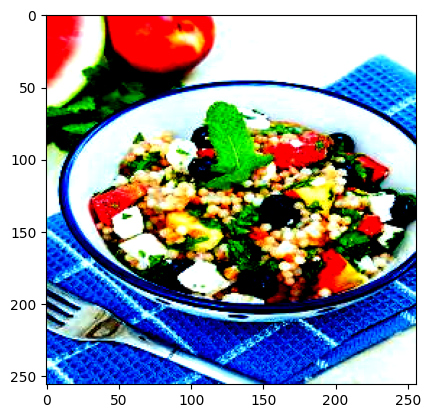

(256, 256, 3)
[[0.20878811 0.20878811 0.20878811 ... 0.39215687 0.39215687 0.39215687]
 [0.20878811 0.20878811 0.20878811 ... 0.39215687 0.39215687 0.39215687]
 [0.20878811 0.20878811 0.20878811 ... 0.39215687 0.39215687 0.39215687]
 ...
 [0.137365   0.14507219 0.20206226 ... 0.39215687 0.39215687 0.39215687]
 [0.13619217 0.16381358 0.19897461 ... 0.39215687 0.39215687 0.39215687]
 [0.19691616 0.20775889 0.11663698 ... 0.39186963 0.39186963 0.3907447 ]]
[[[ 0.6257324   0.5250244 ]
  [ 0.6257324   0.5250244 ]
  [ 0.6257324   0.5250244 ]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.6257324   0.5250244 ]
  [ 0.6257324   0.5250244 ]
  [ 0.6257324   0.5250244 ]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 [[ 0.6257324   0.5250244 ]
  [ 0.6257324   0.5250244 ]
  [ 0.6257324   0.5250244 ]
  ...
  [ 0.          0.        ]
  [ 0.          0.        ]
  [ 0.          0.        ]]

 ...

 [[ 0.55

In [43]:

print(img.shape)
img = np.moveaxis(img, 0, 2)
plt.imshow(img)
plt.show()
print(img.shape)
lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
L = lab[:,:,0]/255.0
ab = lab[:,:,1:]/128.0
print(L)
print(ab)

In [10]:
def process_batch(batch):
    L_batch = []
    ab_batch = []
    for img in batch:
        img = img.cpu().numpy()
        img = np.moveaxis(img, 0, 2)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        L = lab[:,:,0]/255.0
        ab = lab[:,:,1:]/128.0
        ab = np.moveaxis(ab, 2, 0)
        L_batch.append(torch.tensor(L, dtype=torch.float32).unsqueeze(0).unsqueeze(0))
        ab_batch.append(torch.tensor(ab, dtype=torch.float32).unsqueeze(0))
    L_batch = torch.cat(L_batch,dim=0)
    ab_batch = torch.cat(ab_batch,dim=0)
    return L_batch,ab_batch

In [66]:
batch = next(iter(train))
L_batch,ab_batch = process_batch(batch[0])

In [67]:
print(L_batch.shape)
print(ab_batch.shape)

torch.Size([128, 1, 256, 256])
torch.Size([128, 2, 256, 256])


In [ ]:
colorizer = ColorizationModel()

optimizer = torch.optim.Adam(colorizer.parameters(), lr=1e-3)
criterion = nn.MSELoss()  # Reconstruction loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
colorizer.to(device)



train_loss = []
val_loss = []

num_epochs = 20
best_val_loss = float('inf')  # Initialize the best validation loss to infinity
best_model_path = 'self-supervised/models/best_sparse_AE.pth'  # Path to save the best model

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    colorizer.train()
    running_loss = 0.0
    print('Training:')
    i = 0
    for inputs, _ in train:
        
        i = i + 1
        if i % 20 == 0:
            print(f'Batch {i} di {len(train)}')
        L,ab = process_batch(inputs)
        inputs = L.to(device)
        labels = ab.to(device)
        optimizer.zero_grad()
        outputs = colorizer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_epoch = running_loss / len(train)
    print(f'Train_Loss: {train_loss_epoch}')
    train_loss.append(train_loss_epoch)
    
    colorizer.eval()
    running_loss = 0.0
    print('Validation:')
    i = 0
    for inputs, _ in val:
        i = i + 1
        if i % 20 == 0:
            print(f'Batch {i} di {len(val)}')
        L,ab = process_batch(inputs)
        inputs = L.to(device)
        labels = ab.to(device)
        outputs = colorizer(inputs)
        loss = criterion(outputs, ab)
        running_loss += loss.item()
    val_loss_epoch = running_loss / len(val)
    print(f'Validation_Loss: {val_loss_epoch}')
    val_loss.append(val_loss_epoch)

    # Save the model if the validation loss improves
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        torch.save(colorizer.state_dict(), best_model_path)
        print(f'Best model saved with validation loss: {best_val_loss}')

Epoch 1
Training:
